# Loan Eligibility Prediction

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler,LabelEncoder
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')


## Loading the Improved Dataset

In [4]:

# Load the updated dataset
file_path = "loan_eligibility_dataset.csv"
df = pd.read_csv(file_path)

# Display first few rows
print(df)


      Age    Income  Expenses  CIBIL_Score  Experience Employment_Stability  \
0      59   48054.0   56248.0          381          38            Permanent   
1      49  294703.5   62021.4          723          32            Permanent   
2      35   49849.5   35259.7          785          37            Permanent   
3      63  264210.0   51097.2          795           7            Permanent   
4      28  128590.5   29607.9          729          23            Permanent   
...   ...       ...       ...          ...         ...                  ...   
4995   53   70903.0   36949.0          880          23       Contract Based   
4996   52   85792.0   73376.0          744          17            Permanent   
4997   49   53439.0   84587.0          438          26            Permanent   
4998   41  184329.0   98059.0          495          23            Permanent   
4999   41  293619.0   50617.0          717          28            Permanent   

     Employment_Type       Loan_Type             Pu

In [5]:
for column in df.columns:
    print(f"Column: {column}")
    print(df[column].unique())  # Print unique values in the column
    print("-" * 50)  # Separator for readability


Column: Age
[59 49 35 63 28 41 39 43 31 44 56 60 23 42 22 64 50 58 53 32 45 47 62 48
 36 57 27 29 38 24 34 46 40 55 37 26 54 30 51 61 21 25 33 52]
--------------------------------------------------
Column: Income
[ 48054.  294703.5  49849.5 ...  53439.  184329.  293619. ]
--------------------------------------------------
Column: Expenses
[56248.  62021.4 35259.7 ... 84587.  98059.  50617. ]
--------------------------------------------------
Column: CIBIL_Score
[381 723 785 795 729 806 758 589 769 774 731 791 813 711 745 705 706 702
 828 834 767 738 403 810 736 708 743 750 782 777 808 341 846 789 763 748
 845 830 733 749 735 849 776 716 676 759 870 799 757 715 703 488 812 831
 725 753 734 712 308 787 805 372 710 358 807 770 872 760 835 421 721 481
 741 369 459 821 437 794 546 803 823 542 818 798 580 491 779 606 453 707
 824 780 815 836 426 704 726 797 827 697 564 562 826 837 766 540 521 513
 891 788 775 861 816 718 560 755 574 577 840 509 838 792 379 756 761 796
 880 713 724 843 773 80

## Exploratory Data Analysis and Visualization

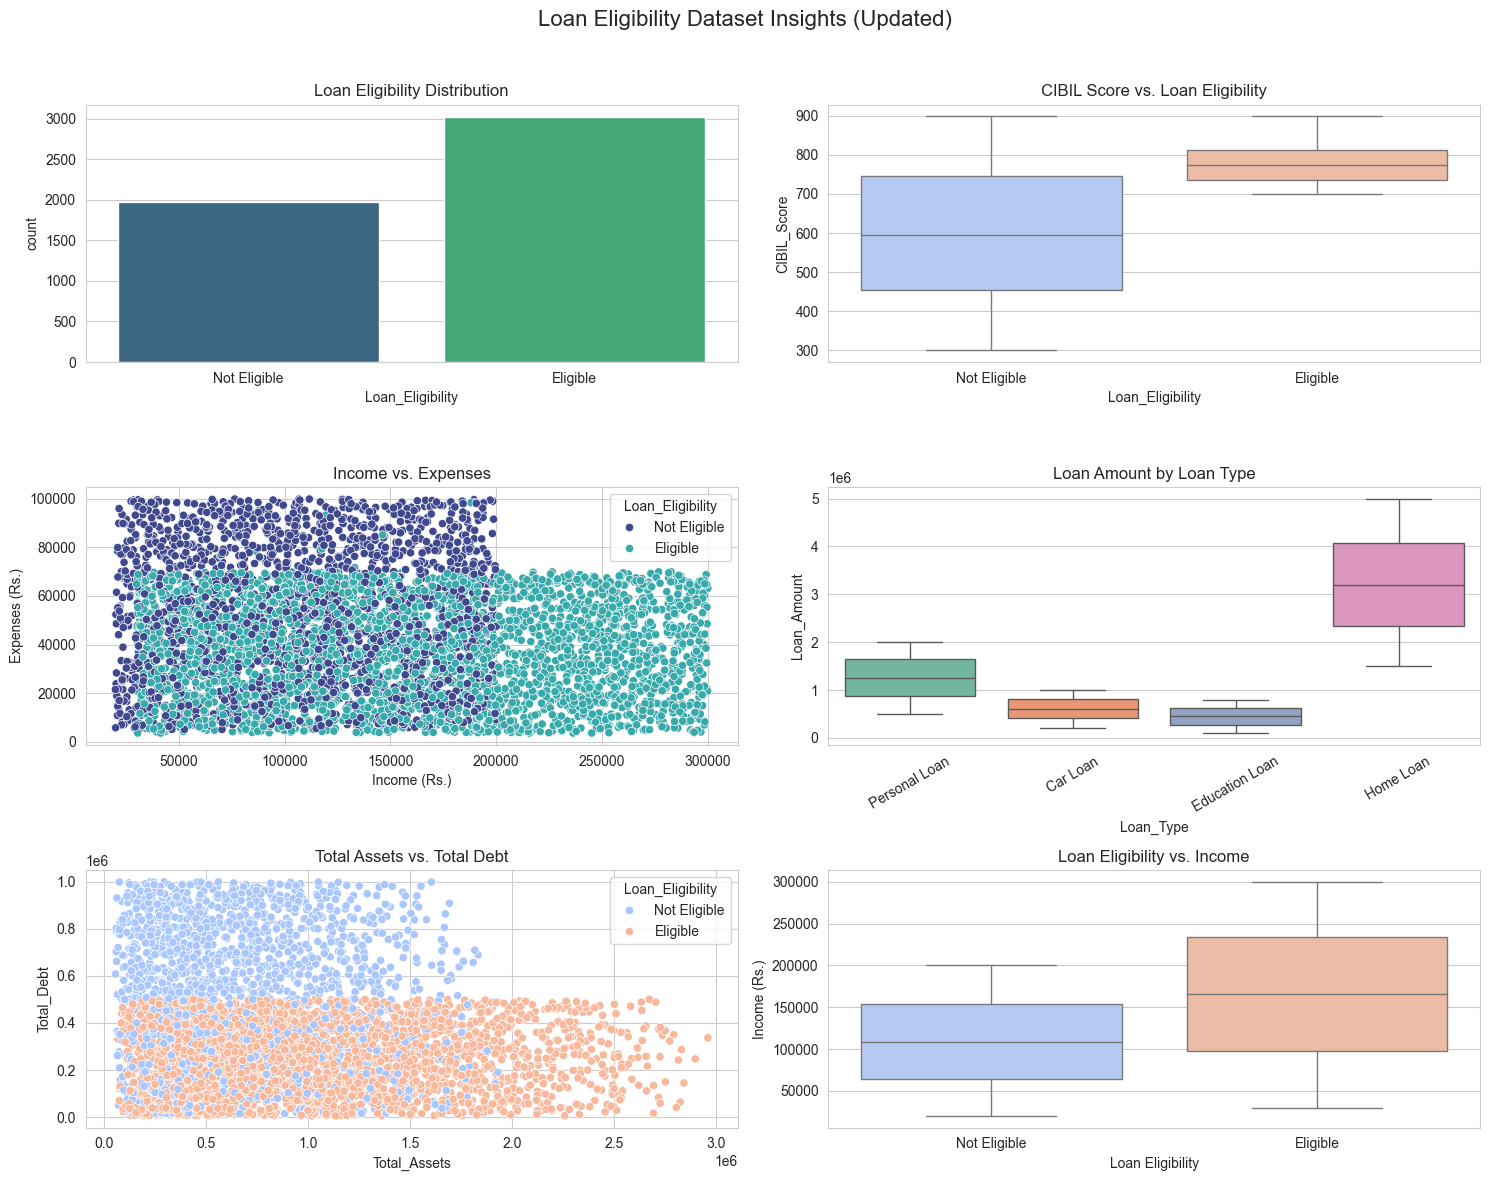

In [6]:

# Clean column names (remove spaces from start and end)
df.columns = df.columns.str.strip()

# Ensure Loan_Eligibility is treated as categorical
df["Loan_Eligibility"] = df["Loan_Eligibility"].astype(str)

# Set plot style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle("Loan Eligibility Dataset Insights (Updated)", fontsize=16)

# 1. Loan Eligibility Distribution
sns.countplot(x="Loan_Eligibility", data=df, palette="viridis", ax=axes[0, 0])
axes[0, 0].set_title("Loan Eligibility Distribution")

# 2. CIBIL Score vs. Loan Eligibility
sns.boxplot(x="Loan_Eligibility", y="CIBIL_Score", data=df, palette="coolwarm", ax=axes[0, 1])
axes[0, 1].set_title("CIBIL Score vs. Loan Eligibility")

# 3. Income vs. Expenses
sns.scatterplot(x="Income", y="Expenses", hue="Loan_Eligibility", data=df, palette="mako", ax=axes[1, 0])
axes[1, 0].set_title("Income vs. Expenses")
axes[1, 0].set_xlabel("Income (Rs.)")
axes[1, 0].set_ylabel("Expenses (Rs.)")

# 4. Loan Amount vs. Loan Type
sns.boxplot(x="Loan_Type", y="Loan_Amount", data=df, palette="Set2", ax=axes[1, 1])
axes[1, 1].set_title("Loan Amount by Loan Type")
axes[1, 1].tick_params(axis='x', rotation=30)

# 5. Total Assets vs. Total Debt
sns.scatterplot(x="Total_Assets", y="Total_Debt", hue="Loan_Eligibility", data=df, palette="coolwarm", ax=axes[2, 0])
axes[2, 0].set_title("Total Assets vs. Total Debt")

# 6. Loan Eligibility vs. Income
sns.boxplot(x="Loan_Eligibility", y="Income", data=df, palette="coolwarm", ax=axes[2, 1])
axes[2, 1].set_title("Loan Eligibility vs. Income")
axes[2, 1].set_xlabel("Loan Eligibility")
axes[2, 1].set_ylabel("Income (Rs.)")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show plots
plt.show()


## Data Preprocessing and Feature Engineering

In [7]:

# Handling missing values (Fill numerical missing values with median)
df.fillna(df.median(numeric_only=True), inplace=True)


# **Step 1: Split Data into Features (X) and Targets (y1, y2, y3)**
X = df.drop(columns=["Loan_Eligibility", "Interest_Rate", "Loan_Tenure"])  # Features
y1 = df["Loan_Eligibility"]  # Target 1: Loan Approval
y2 = df["Interest_Rate"]      # Target 2: Interest Rate
y3 = df["Loan_Tenure"]        # Target 3: Loan Duration


# Convert Loan_Eligibility to binary (0 = Not Eligible, 1 = Eligible)
y1 = y1.map({"Eligible": 1, "Not Eligible": 0})

# **Step 2: Add Derived Features to X**
X["Debt-to-Income Ratio"] = X["Total_Debt"] / X["Income"]
X["Loan-to-Value Ratio"] = X["Loan_Amount"] / X["Total_Assets"]  # Assuming Total_Assets as property value
X["Employment_Stability_Score"] = X["Experience"] * X["Salary_Growth"]  # Experience * Salary Growth

# **Step 3: Label Encoding for Categorical Variables**
categorical_columns = ["Employment_Stability", "Employment_Type", "Loan_Type", "Purpose", "Education",
                       "Collateral", "Insurance", "Tax_History", "Residence_Type","Residence"]

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])  # Convert categorical to numerical
    label_encoders[col] = le  # Store encoder for future use

    # Convert categorical columns to numerical using Label Encoding
for col in categorical_columns:
    if X[col].dtype == "object":
        X[col] = label_encoders[col].fit_transform(X[col])


# Display first few rows of X
print(X.head())


   Age    Income  Expenses  CIBIL_Score  Experience  Employment_Stability  \
0   59   48054.0   56248.0          381          38                     2   
1   49  294703.5   62021.4          723          32                     2   
2   35   49849.5   35259.7          785          37                     2   
3   63  264210.0   51097.2          795           7                     2   
4   28  128590.5   29607.9          729          23                     2   

   Employment_Type  Loan_Type  Purpose  Education  ...  Insurance  \
0                2          3        2          2  ...          1   
1                1          0        0          3  ...          1   
2                1          1        1          1  ...          1   
3                1          2        2          1  ...          1   
4                1          3        3          2  ...          1   

   Tax_History  Residence_Type  Residence  Total_Debt  Salary_Growth  \
0            1               1          0    74067

## Train-Test Split

In [8]:
# Train-Test Split (80% Train, 20% Test)**
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)
_, _, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)
_, _, y3_train, y3_test = train_test_split(X, y3, test_size=0.2, random_state=42)

# Print all column names in the original dataframe
print("Columns in df (Original Dataset):")
print(df.columns.tolist())

# Print feature columns in X
print("\nColumns in X (Features):")
print(X.columns.tolist())

# Print the target columns
print("\nTarget Variable: y1 (Loan Eligibility)")
print(y1.name)  # Should print 'Loan_Eligibility'

print("\nTarget Variable: y2 (Interest Rate)")
print(y2.name)  # Should print 'Interest_Rate'

print("\nTarget Variable: y3 (Loan Tenure)")
print(y3.name)  # Should print 'Loan_Tenure'


Columns in df (Original Dataset):
['Age', 'Income', 'Expenses', 'CIBIL_Score', 'Experience', 'Employment_Stability', 'Employment_Type', 'Loan_Type', 'Purpose', 'Education', 'Loan_Amount', 'Loan_Tenure', 'Collateral', 'Insurance', 'Tax_History', 'Residence_Type', 'Interest_Rate', 'Residence', 'Total_Debt', 'Salary_Growth', 'Loan_Eligibility', 'Total_Assets']

Columns in X (Features):
['Age', 'Income', 'Expenses', 'CIBIL_Score', 'Experience', 'Employment_Stability', 'Employment_Type', 'Loan_Type', 'Purpose', 'Education', 'Loan_Amount', 'Collateral', 'Insurance', 'Tax_History', 'Residence_Type', 'Residence', 'Total_Debt', 'Salary_Growth', 'Total_Assets', 'Debt-to-Income Ratio', 'Loan-to-Value Ratio', 'Employment_Stability_Score']

Target Variable: y1 (Loan Eligibility)
Loan_Eligibility

Target Variable: y2 (Interest Rate)
Interest_Rate

Target Variable: y3 (Loan Tenure)
Loan_Tenure


Why Random_state=42? 
If you don’t set random_state to 42, every time you run your code again, it will generate a different test set. Over time, you (or your machine learning algorithm) will be able to see the dataset, which you want to avoid.

One solution is to save the test set on the first run, and then load it on subsequent runs. Another option is to set the start value of the random number generator (for example, with np.random.seed(42)) so that it always generates the same clues mixed up.

## Training Using Naïve Bayes and Bayesian Regression

In [9]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import BayesianRidge

# Loan Eligibility Model (Classification) - Using Gaussian Naïve Bayes
eligibility_model = GaussianNB()  # Or MultinomialNB(), BernoulliNB() based on data
eligibility_model.fit(X_train, y1_train)

# Interest Rate Prediction Model (Regression) - Using Bayesian Ridge Regression
interest_model = BayesianRidge()
interest_model.fit(X_train, y2_train)

# Loan Tenure Prediction Model (Regression) - Using Bayesian Ridge Regression
tenure_model = BayesianRidge()
tenure_model.fit(X_train, y3_train)

# Display dataset shapes
print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)
print("y1_train Shape:", y1_train.shape)
print("y1_test Shape:", y1_test.shape)


X_train Shape: (4000, 22)
X_test Shape: (1000, 22)
y1_train Shape: (4000,)
y1_test Shape: (1000,)


## Model Evaluation

In [10]:

# Predicting on Test Set
y1_pred = eligibility_model.predict(X_test)
y2_pred = interest_model.predict(X_test)
y3_pred = tenure_model.predict(X_test)

# Loan Eligibility Model Evaluation
accuracy = accuracy_score(y1_test, y1_pred)
print(f"Loan Eligibility Model Accuracy: {accuracy * 100:.2f}%")

# Interest Rate Model Evaluation
mae_interest = mean_absolute_error(y2_test, y2_pred)
mse_interest = mean_squared_error(y2_test, y2_pred)
print(f"Interest Rate Model MAE: {mae_interest:.2f}, MSE: {mse_interest:.2f}")

# Loan Tenure Model Evaluation
mae_tenure = mean_absolute_error(y3_test, y3_pred)
mse_tenure = mean_squared_error(y3_test, y3_pred)
print(f"Loan Tenure Model MAE: {mae_tenure:.2f}, MSE: {mse_tenure:.2f}")


Loan Eligibility Model Accuracy: 92.90%
Interest Rate Model MAE: 2.54, MSE: 8.54
Loan Tenure Model MAE: 7.38, MSE: 71.17


## Pipeline

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
 
# **Step 1: Identify Features**
categorical_features = ["Employment_Stability", "Employment_Type", "Loan_Type", "Purpose", "Education",
                        "Collateral", "Insurance", "Tax_History", "Residence_Type", "Residence"]

numerical_features = ["Age", "Income", "Expenses", "CIBIL_Score", "Experience",
                      "Loan_Amount", "Total_Debt", "Salary_Growth", "Total_Assets"]

# **Step 2: Function to Compute Derived Features**
def add_derived_features(X):
    X = X.copy()  # Avoid modifying original data
    X["Debt-to-Income Ratio"] = X["Total_Debt"] / X["Income"]
    X["Loan-to-Value Ratio"] = X["Loan_Amount"] / X["Total_Assets"]
    X["Employment_Stability_Score"] = X["Experience"] * X["Salary_Growth"]
    return X

# **Step 3: Define Preprocessing Pipeline**
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_features),  # Scale numerical features
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),  # Encode categorical features
        ("derived", FunctionTransformer(add_derived_features), numerical_features)  # Add derived features
    ]
)

# **Step 4: Define Pipelines for Each Model**
eligibility_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", GaussianNB())
])

interest_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", BayesianRidge())
])

tenure_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", BayesianRidge())
])

# **Step 5: Train Pipelines**
eligibility_pipeline.fit(X_train, y1_train)
interest_pipeline.fit(X_train, y2_train)
tenure_pipeline.fit(X_train, y3_train)

# **Step 6: Evaluate Models**
y1_pred = eligibility_pipeline.predict(X_test)
y2_pred = interest_pipeline.predict(X_test)
y3_pred = tenure_pipeline.predict(X_test)

print(f"Loan Eligibility Model Accuracy: {accuracy_score(y1_test, y1_pred) * 100:.2f}%")
print(f"Interest Rate Model MAE: {mean_absolute_error(y2_test, y2_pred):.2f}, MSE: {mean_squared_error(y2_test, y2_pred):.2f}")
print(f"Loan Tenure Model MAE: {mean_absolute_error(y3_test, y3_pred):.2f}, MSE: {mean_squared_error(y3_test, y3_pred):.2f}")


Loan Eligibility Model Accuracy: 92.90%
Interest Rate Model MAE: 2.54, MSE: 8.54
Loan Tenure Model MAE: 7.38, MSE: 71.17


In [12]:
from sklearn import set_config
set_config(display="diagram")
eligibility_pipeline

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
set_config(display="diagram")
eligibility_pipeline
interest_pipeline

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
from sklearn import set_config
set_config(display="diagram")
tenure_pipeline

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Predicting an Example Loan

### Example 1: Eligible Candidate

In [15]:
import numpy as np
import pandas as pd

# **Step 1: Example Candidate Details (Raw Features)**
example_candidate = {
    "Age": 25,
    "Income": 55000,
    "Expenses": 5000,
    "CIBIL_Score": 800,
    "Experience": 3,
    "Employment_Stability": "Stable",  # Categorical
    "Employment_Type": "Salaried",  # Categorical
    "Loan_Type": "Home Loan",  # Categorical
    "Purpose": "House Purchase",  # Categorical
    "Education": "Graduate",  # Categorical
    "Loan_Amount": 100000,
    "Collateral": "Yes",  # Categorical
    "Insurance": "Yes",  # Categorical
    "Tax_History": "Good",  # Categorical
    "Residence_Type": "Owned",  # Categorical
    "Residence": "Urban",  # Categorical
    "Total_Debt": 20000,
    "Salary_Growth": 8,
    "Total_Assets": 500000,
}

# **Step 2: Convert to DataFrame**
example_df = pd.DataFrame([example_candidate])

# **Predict using Pipelines**
eligibility_pred = eligibility_pipeline.predict(example_df)
interest_pred = interest_pipeline.predict(example_df)
tenure_pred = tenure_pipeline.predict(example_df)
 
# **Step 5: Display Results**
print(f"✅ Predicted Loan Eligibility: {'Eligible' if eligibility_pred[0] == 1 else 'Not Eligible'}")
print(f"✅ Predicted Interest Rate: {interest_pred[0]:.2f}%")
print(f"✅ Predicted Loan Tenure: {tenure_pred[0]:.2f} years")


✅ Predicted Loan Eligibility: Eligible
✅ Predicted Interest Rate: 9.89%
✅ Predicted Loan Tenure: 14.88 years
